# Escolher algum ambiente

Foi escolhido como ambiente de estudo o '**Intersection**', disponível em: http://highway-env.farama.org/environments/intersection/

In [1]:
import aux_functions

STACK_SIZE = 4

env = aux_functions.intersection_v1(STACK_SIZE = STACK_SIZE)

In [2]:
env.reset()

for _ in range(15):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done or truncated:
        obs, info = env.reset()
env.close()

## Observações no formato de imagem

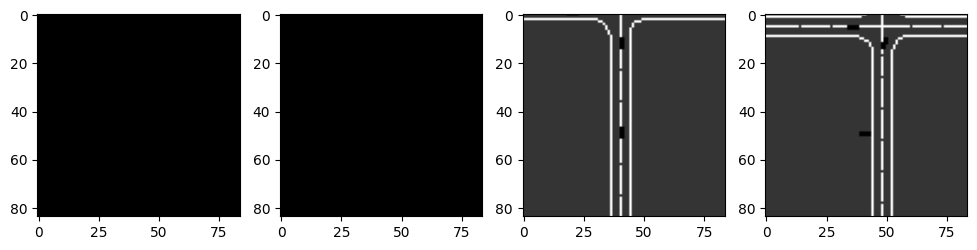

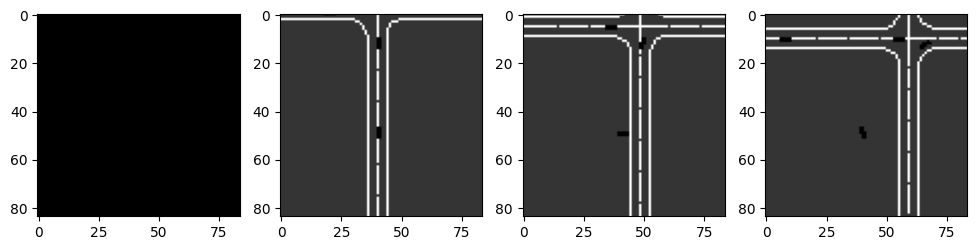

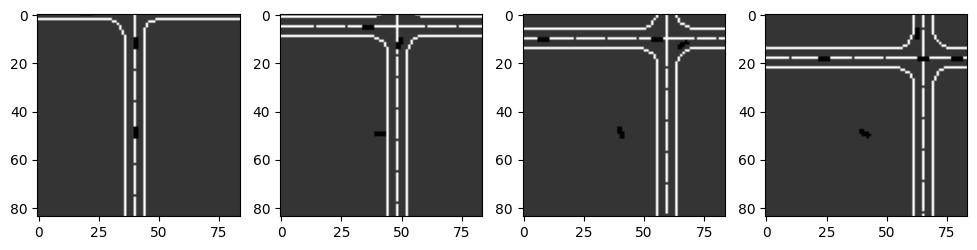

In [3]:
from matplotlib import pyplot as plt

env.reset()

for _ in range(3):
    obs, reward, done, truncated, info = env.step(env.action_space.sample())

    fig, axes = plt.subplots(ncols = STACK_SIZE, figsize=(12, 5))

    if STACK_SIZE > 1:
        for i, ax in enumerate(axes.flat):
            ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
    else:
        axes.imshow(obs[0, ...].T, cmap=plt.get_cmap('gray'))

plt.show()

# Escolher algoritmos

In [9]:
import tensorboard
%load_ext tensorboard

%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7176), started 0:10:19 ago. (Use '!kill 7176' to kill it.)

In [12]:
import numpy as np

TOTAL_TIMESTEPS = 500_000/1000
LOG_INTERVAL = max(np.round(TOTAL_TIMESTEPS / 100), 1)
BUFFER_SIZE = 25_000

## DDPG (baseline)

In [13]:
from stable_baselines3 import DDPG

env.reset()

ddpg = DDPG("CnnPolicy", env, verbose=0, buffer_size=BUFFER_SIZE, tensorboard_log="logs")
ddpg.learn(total_timesteps=TOTAL_TIMESTEPS, log_interval=LOG_INTERVAL, progress_bar=True)
ddpg.save("ddpg_intersection")

Output()

In [8]:
# from stable_baselines3 import DDPG
ddpg = DDPG.load("ddpg_intersection")

aux_functions.render_model(ddpg, env)

## SAC (state of art)

### Otimização de hiper-parâmetros

In [6]:
import optuna
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy

TOTAL_TIMESTEPS_OPTUNA = 100_000/1000
LOG_INTERVAL_OPTUNA = max(np.round(TOTAL_TIMESTEPS_OPTUNA / 100), 1)
N_EVAL_EPISODES = 10

def train_sac_intersection(trial : optuna.Trial):
    # Parametros de teste
    lr = trial.suggest_categorical('learning rate', [0.00015, 0.0003, 0.00045]) # learning rate for adam optimizer, the same learning rate will be used for
                                                                  # all networks (Q-Values, Actor and Value function) it can be a function of
                                                                  # the current progress remaining (from 1 to 0)
    ls = trial.suggest_categorical('learning starts', [50, 100, 150]) # how many steps of the model to collect transitions for before learning starts
    tau = trial.suggest_categorical('tau', [0.0025, 0.005, 0.0075]) # the soft update coefficient (“Polyak update”, between 0 and 1)

    # Ambiente de teste
    print(f"\nTRIAL #{trial.number}: {trial.params}")

    env = aux_functions.intersection_v1(STACK_SIZE = STACK_SIZE)
    env.reset()

    model = SAC("CnnPolicy", env,
                learning_rate = lr,
                learning_starts = ls,
                tau = tau,
                verbose = 0, buffer_size = BUFFER_SIZE)
    model.learn(total_timesteps=TOTAL_TIMESTEPS_OPTUNA, log_interval=LOG_INTERVAL_OPTUNA)

    env.reset()

    results = evaluate_policy(model, env, n_eval_episodes=N_EVAL_EPISODES)

    env.close()

    return results[0]

In [7]:
study = optuna.create_study(direction = "maximize",
                            storage = 'sqlite:///sac_optimization.db',
                            # study_name = 'sac_intersection_v1',
                            study_name = 'teste_final',
                            load_if_exists = True)

N_TRIALS = 5
study.optimize(train_sac_intersection, n_trials = N_TRIALS, n_jobs = 5)

print("MELHORES PARÂMETROS:")
print(study.best_params)

[I 2024-02-27 12:56:52,601] Using an existing study with name 'teste_final' instead of creating a new one.



TRIAL #37: {'learning rate': 0.0003, 'learning starts': 50, 'tau': 0.005}

TRIAL #33: {'learning rate': 0.0003, 'learning starts': 50, 'tau': 0.005}

TRIAL #36: {'learning rate': 0.0003, 'learning starts': 50, 'tau': 0.005}

TRIAL #34: {'learning rate': 0.0003, 'learning starts': 50, 'tau': 0.005}

TRIAL #35: {'learning rate': 0.0003, 'learning starts': 50, 'tau': 0.005}


c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2024-02-27 12:59:05,471] Trial 37 finished with value: 3.2246497631073 and parameters: {'learning rate': 0.0003, 'learning starts': 50, 'tau': 0.005}. Best is trial 37 with value: 3.2246497631073.
[I 2024-02-27 12:59:23,081] Trial 33 finished with value: 3.117611312866211 and parameters: {'learning rate': 0.0003, 'learning starts': 50, 'tau': 0.005}. Best is trial 37 with value: 3.2246497631073.
[I 2024-02-27 12:59:29,809] Trial 35 finished with value: 1.2319405555725098 and parameters: {'learning rate': 0.0003, 'learning starts': 50, 'tau': 0.005}. Best is trial 37 with value: 3.2246497631073.
[I 2024-02-2

MELHORES PARÂMETROS:
{'learning rate': 0.0003, 'learning starts': 50, 'tau': 0.005}


In [1]:
# import os
# import optuna

# os.cpu_count()
# optuna.delete_study(study_name = 'sac_intersection_v1', storage = 'sqlite:///sac_optimization.db')

### Treinamento

In [11]:
study.best_params

{'learning rate': 0.0003, 'learning starts': 50, 'tau': 0.005}

In [12]:
env.reset()

lr = study.best_params['learning rate']
ls = study.best_params['learning starts']
tau = study.best_params['tau']

sac = SAC("CnnPolicy", env,
                learning_rate = lr,
                learning_starts = ls,
                tau = tau,
                verbose=1, buffer_size=BUFFER_SIZE)
sac.learn(total_timesteps=TOTAL_TIMESTEPS, log_interval=LOG_INTERVAL, progress_bar=True)
sac.save("ddpg_intersection")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.68     |
|    ep_rew_mean     | 0.123    |
| time/              |          |
|    episodes        | 25       |
|    fps             | 6        |
|    time_elapsed    | 25       |
|    total_timesteps | 167      |
| train/             |          |
|    actor_loss      | -2.58    |
|    critic_loss     | 1.21     |
|    ent_coef        | 0.966    |
|    ent_coef_loss   | -0.116   |
|    learning_rate   | 0.0003   |
|    n_updates       | 116      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.52     |
|    ep_rew_mean     | 0.161    |
| time/              |          |
|    episodes        | 50       |
|    fps             | 6        |
|    time_elapsed    | 51       |
|    total_timesteps | 326      |
| train/             |          |
|    actor_loss      | -2.7     |
|    critic_loss     | 0.196    |
|    ent_coef        | 0.921    |
|    ent_coef_loss   | -0.275   |
|    learning_rate   | 0.0003   |
|    n_updates       | 275      |
---------------------------------


In [10]:
# from stable_baselines3 import SAC
sac = SAC.load("sac_intersection")

aux_functions.render_model(ddpg, env)

/home/avlis/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 2.20GB
  warnings.warn(


# Outros

In [20]:
model = SAC.load("sac_intersection")
model.policy

/home/avlis/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.56GB > 2.39GB
  warnings.warn(


CnnPolicy(
  (actor): Actor(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_dim=-1)
      )
      (linear): Sequential(
        (0): Linear(in_features=3072, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (mu): Linear(in_features=256, out_features=2, bias=True)
    (log_std): Linear(in_features=256, out_features=2, bias=True)
  )
  (critic): ContinuousCritic(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4

In [22]:
model = DDPG.load("ddpg_intersection")
model.policy

/home/avlis/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.56GB > 2.24GB
  warnings.warn(


CnnPolicy(
  (actor): Actor(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_dim=-1)
      )
      (linear): Sequential(
        (0): Linear(in_features=3072, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (mu): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=2, bias=True)
      (5): Tanh()
    )
  )
  (actor_target): Actor(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kerne